In [3]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal

# 프로젝트 루트 경로 설정 (notebooks 폴더 상위의 src 폴더를 참조)
project_root = Path("..").resolve()
sys.path.append(str(project_root / "src"))

# bt 패키지 임포트
from bt.domain.models import BacktestConfig
from bt.domain.types import Amount, Fee, Percentage
from bt.engine.backtest import BacktestEngine
from bt.strategies import conditions, pricing, allocation
from bt.strategies.vbo import get_vbo_strategy
from bt.reporting.metrics import calculate_performance_metrics

# 차트 스타일 설정
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [11]:
def load_data(symbols, interval="day"):
    data_map = {}
    base_data_dir = project_root / "data" / interval # 데이터 경로 확인 필요 (bt/data 인지 data 인지)
    
    # 만약 bt/data 구조라면 아래 주석 해제
    # base_data_dir = project_root / "bt" / "data" / interval 

    print(f"Loading data from: {base_data_dir}")
    
    for symbol in symbols:
        file_path = base_data_dir / f"{symbol}.parquet"
        if file_path.exists():
            df = pd.read_parquet(file_path)
            df["datetime"] = pd.to_datetime(df["datetime"])
            data_map[symbol] = df
            print(f"Loaded {symbol}: {len(df)} rows")
        else:
            print(f"File not found: {file_path}")
            
    return data_map

def add_vbo_indicators(df, lookback=5, multiplier=2):
    """지표를 미리 계산하여 DataFrame에 추가 (Vectorization)"""
    df = df.copy()
    
    # 1. 노이즈 계산 (Vectorized)
    # noise = |open - close| / (high - low)
    range_hl = df["high"] - df["low"]
    noise = (df["open"] - df["close"]).abs() / range_hl.replace(0, 1e-9)
    
    # 2. 이동평균 계산 (Shift 1: 어제까지의 데이터로 계산해야 함)
    # rolling().mean()은 현재 행을 포함하므로, 어제 기준 값을 쓰려면 shift(1) 필수
    df["noise_ma_short"] = noise.rolling(lookback).mean().shift(1)
    df["noise_ma_long"] = noise.rolling(lookback * multiplier).mean().shift(1)
    df["close_ma_short"] = df["close"].rolling(lookback).mean().shift(1)
    df["close_ma_long"] = df["close"].rolling(lookback * multiplier).mean().shift(1)
    
    # 3. 목표 매수가(Breakout Price) 미리 계산
    # Target = TodayOpen + (YesterdayRange * YesterdayNoiseMA)
    # range_hl.shift(1) -> 어제 변동폭
    breakout_step = range_hl.shift(1) * df["noise_ma_short"]
    df["vbo_target_price"] = df["open"] + breakout_step
    
    return df

# 사용할 종목과 데이터 로드
symbols = ["BTC", "ETH", "XRP", "TRX"]
interval = "day"
market_data = load_data(symbols, interval)

# 데이터 로드 후 전처리 적용
market_data_optimized = {
    sym: add_vbo_indicators(df) for sym, df in market_data.items()
}

Loading data from: C:\workspace\dev\bt\data\day
Loaded BTC: 3029 rows
Loaded ETH: 3026 rows
Loaded XRP: 3026 rows
Loaded TRX: 2837 rows


In [10]:
from decimal import Decimal

# --- 최적화된 매수/매도 조건 함수 ---

def fast_breakout(engine, symbol):
    bar = engine.get_bar(symbol)
    # 데이터가 없는 초기 구간 처리
    if pd.isna(bar["vbo_target_price"]): return False
    
    # High >= Target Price
    return Decimal(str(bar["high"])) >= Decimal(str(bar["vbo_target_price"]))

def fast_trend_short(engine, symbol):
    bar = engine.get_bar(symbol)
    if pd.isna(bar["vbo_target_price"]) or pd.isna(bar["close_ma_short"]): return False
    
    # Target Price > Short MA
    return Decimal(str(bar["vbo_target_price"])) > Decimal(str(bar["close_ma_short"]))

def fast_trend_long(engine, symbol):
    bar = engine.get_bar(symbol)
    if pd.isna(bar["vbo_target_price"]) or pd.isna(bar["close_ma_long"]): return False
    
    # Target Price > Long MA
    return Decimal(str(bar["vbo_target_price"])) > Decimal(str(bar["close_ma_long"]))

def fast_low_noise(engine, symbol):
    bar = engine.get_bar(symbol)
    if pd.isna(bar["noise_ma_short"]) or pd.isna(bar["noise_ma_long"]): return False
    
    # Short Noise MA < Long Noise MA
    return Decimal(str(bar["noise_ma_short"])) < Decimal(str(bar["noise_ma_long"]))

def fast_stop_trend(engine, symbol):
    bar = engine.get_bar(symbol)
    if pd.isna(bar["close_ma_short"]): return False
    
    # Close < Short MA
    return Decimal(str(bar["close"])) < Decimal(str(bar["close_ma_short"]))

# --- 최적화된 가격 결정 함수 ---

def fast_get_buy_price(engine, symbol):
    bar = engine.get_bar(symbol)
    if pd.isna(bar["vbo_target_price"]): return Decimal("0")
    return Decimal(str(bar["vbo_target_price"]))

In [5]:
def run_experiment(config_params, strategy_components, data_map):
    # 1. 설정 생성
    config = BacktestConfig(
        initial_cash=Amount(Decimal(str(config_params.get("initial_cash", 10_000_000)))),
        fee=Fee(Decimal(str(config_params.get("fee", 0.0005)))),
        slippage=Percentage(Decimal(str(config_params.get("slippage", 0.0005)))),
        multiplier=config_params.get("multiplier", 2),
        lookback=config_params.get("lookback", 5),
        interval=config_params.get("interval", "day"),
    )
    
    # 2. 엔진 초기화 및 데이터 주입
    engine = BacktestEngine(config)
    for symbol, df in data_map.items():
        engine.load_data(symbol, df)
        
    # 3. 백테스트 실행
    engine.run(
        symbols=list(data_map.keys()),
        buy_conditions=strategy_components["buy_conditions"],
        sell_conditions=strategy_components["sell_conditions"],
        buy_price_func=strategy_components["buy_price_func"],
        sell_price_func=strategy_components["sell_price_func"],
        allocation_func=strategy_components["allocation_func"],
    )
    
    # 4. 성과 측정
    metrics = calculate_performance_metrics(
        equity_curve=engine.portfolio.equity_curve,
        dates=engine.portfolio.dates,
        trades=engine.portfolio.trades,
        _initial_cash=config.initial_cash,
    )
    
    return metrics, engine

# 백테스트

Running Optimized VBO Strategy...
CAGR: 118.43%
MDD: -24.42%
Sortino: 3.22
Win Rate: 34.18%
Profit Factor: 1.63


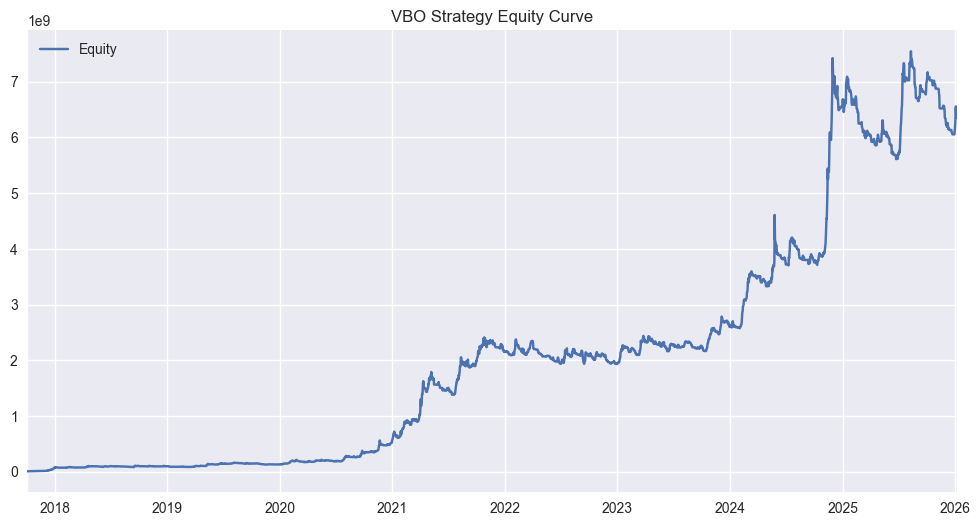

In [ ]:
# 기본 VBO 전략 가져오기
vbo_strategy = get_vbo_strategy()

# 자산 배분 함수 추가 (Cash Partition)
vbo_strategy["allocation_func"] = allocation.create_cash_partition_allocator(symbols)

# 파라미터 설정
base_params = {
    "lookback": 5,      # 이동평균 기간
    "multiplier": 2,    # 노이즈 승수 (k값과 관련)
}

# 실행
# 최적화된 전략 딕셔너리 구성
fast_vbo_strategy = {
    "buy_conditions": {
        "no_pos": conditions.no_open_position, # 기존 함수 재사용
        "breakout": fast_breakout,
        "trend_short": fast_trend_short,
        "trend_long": fast_trend_long,
        #"low_noise": fast_low_noise,
    },
    "sell_conditions": {
        "has_pos": conditions.has_open_position, # 기존 함수 재사용
        "stop_trend": fast_stop_trend,
    },
    "buy_price_func": fast_get_buy_price,
    "sell_price_func": pricing.get_current_close,
    "allocation_func": allocation.create_cash_partition_allocator(symbols),
}

print("Running Optimized VBO Strategy...")
# market_data_optimized를 사용해야 함에 주의!
metrics_fast, engine_fast = run_experiment(base_params, fast_vbo_strategy, market_data_optimized)

# 결과 출력
print(f"CAGR: {metrics_fast.cagr:.2f}%")
print(f"MDD: {metrics_fast.mdd:.2f}%")
print(f"Sortino: {metrics_fast.sortino_ratio:.2f}")
print(f"Win Rate: {metrics_fast.win_rate:.2f}%")
print(f"Profit Factor: {metrics_fast.profit_factor:.2f}")
# 수익 곡선 시각화
equity_values = [float(x) for x in engine_fast.portfolio.equity_curve[1:]]
equity_df = pd.DataFrame({"Equity": equity_values}, index=engine_fast.portfolio.dates)
equity_df.plot(figsize=(12, 6), title="VBO Strategy Equity Curve")
plt.show()

# 최적화

Running parameter sweep...
Lookback 3: CAGR 81.82%, MDD -31.52%
Lookback 5: CAGR 71.14%, MDD -24.73%
Lookback 7: CAGR 83.57%, MDD -35.91%
Lookback 9: CAGR 92.82%, MDD -33.23%
Lookback 11: CAGR 77.47%, MDD -32.32%
Lookback 13: CAGR 84.59%, MDD -37.23%
Lookback 15: CAGR 79.71%, MDD -37.48%
Lookback 17: CAGR 68.33%, MDD -37.12%
Lookback 19: CAGR 65.29%, MDD -31.42%


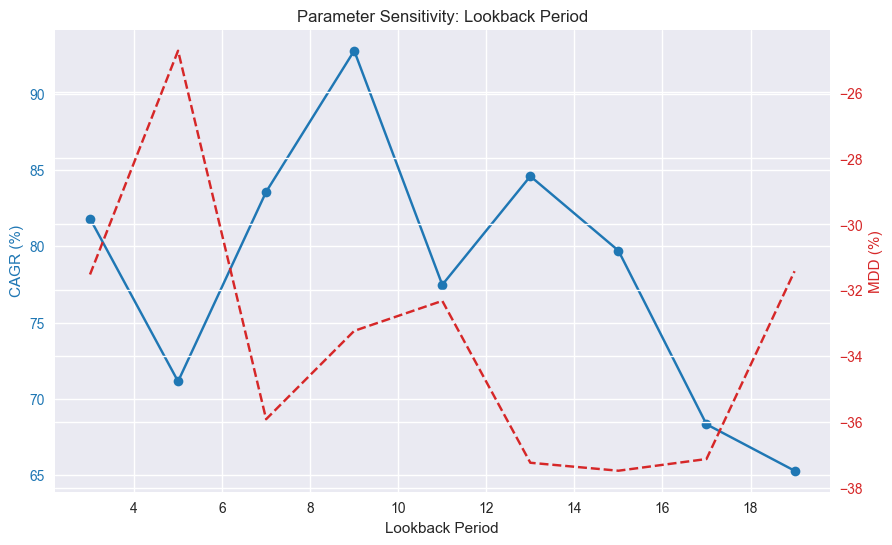

In [13]:
results = []
lookback_range = range(3, 21, 2)  # 3, 5, 7, ... 19

print("Running parameter sweep...")
for k in lookback_range:
    params = base_params.copy()
    params["lookback"] = k
    
    m, _ = run_experiment(params, vbo_strategy, market_data)
    
    results.append({
        "lookback": k,
        "cagr": float(m.cagr),
        "mdd": float(m.mdd),
        "win_rate": float(m.win_rate)
    })
    print(f"Lookback {k}: CAGR {m.cagr:.2f}%, MDD {m.mdd:.2f}%")

# 결과 DataFrame 생성
res_df = pd.DataFrame(results).set_index("lookback")

# 시각화 (Dual Axis)
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Lookback Period')
ax1.set_ylabel('CAGR (%)', color='tab:blue')
ax1.plot(res_df.index, res_df['cagr'], color='tab:blue', marker='o', label='CAGR')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('MDD (%)', color='tab:red')
ax2.plot(res_df.index, res_df['mdd'], color='tab:red', marker='x', linestyle='--', label='MDD')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Parameter Sensitivity: Lookback Period")
plt.show()

# wfa

In [27]:
# 1. 노이즈 제거 전략 정의 (사용자님 코드 그대로 적용)
fast_vbo_strategy_no_noise = {
    "buy_conditions": {
        "no_pos": conditions.no_open_position,
        "breakout": fast_breakout,
        "trend_short": fast_trend_short,
        "trend_long": fast_trend_long,
        # "low_noise": fast_low_noise,  <-- 주석 처리됨 (제거)
    },
    "sell_conditions": {
        "has_pos": conditions.has_open_position,
        "stop_trend": fast_stop_trend,
    },
    "buy_price_func": fast_get_buy_price,
    "sell_price_func": pricing.get_current_close,
    "allocation_func": allocation.create_cash_partition_allocator(symbols),
}

# 2. WFA 래퍼 함수 재정의 (노이즈 없는 전략 사용하도록)
def wfa_wrapper_no_noise(data_map, params=None):
    if params is None: params = {}
    
    # 파라미터 적용 (기본값: Lookback 5, Multiplier 2)
    target_lookback = params.get("lookback", 5)
    target_multiplier = params.get("multiplier", 2)
    
    config = BacktestConfig(
        initial_cash=Amount(Decimal("10000000")),
        fee=Fee(Decimal("0.0005")),
        slippage=Percentage(Decimal("0.0005")),
        multiplier=target_multiplier,
        lookback=target_lookback,
        interval="day",
    )
    
    engine = BacktestEngine(config)
    
    for symbol, df in data_map.items():
        engine.load_data(symbol, df)
        
    # [핵심] 노이즈 제거된 전략 사용
    strategy = fast_vbo_strategy_no_noise.copy()
    strategy["allocation_func"] = allocation.create_cash_partition_allocator(list(data_map.keys()))
    
    engine.run(
        symbols=list(data_map.keys()),
        buy_conditions=strategy["buy_conditions"],
        sell_conditions=strategy["sell_conditions"],
        buy_price_func=strategy["buy_price_func"],
        sell_price_func=strategy["sell_price_func"],
        allocation_func=strategy["allocation_func"],
    )
    
    metrics = calculate_performance_metrics(
        equity_curve=engine.portfolio.equity_curve,
        dates=engine.portfolio.dates,
        trades=engine.portfolio.trades,
        _initial_cash=config.initial_cash,
    )
    
    return {
        "cagr": float(metrics.cagr),
        "mdd": float(metrics.mdd),
        "win_rate": float(metrics.win_rate),
        "sortino_ratio": float(metrics.sortino_ratio),
    }

print("Running WFA (No Noise Filter)...")
wfa_results_no_noise = wfa.run(
    data=market_data_optimized, 
    backtest_func=wfa_wrapper_no_noise
)

summary = wfa_results_no_noise["summary"]
print("\n" + "="*40)
print(f"WFA Summary (No Noise)")
print("="*40)
print(f"Average CAGR: {summary['avg_cagr']:.2f}%")
print(f"Average MDD:  {summary['avg_mdd']:.2f}%")
print(f"Consistency:  {summary['min_cagr']:.2f}% ~ {summary['max_cagr']:.2f}%")

Running WFA (No Noise Filter)...

WFA Summary (No Noise)
Average CAGR: 195.75%
Average MDD:  -11.48%
Consistency:  -30.11% ~ 1457.76%


In [22]:
# Lookback은 5로 고정 (안정성 1위)
fixed_lookback = 5

# 테스트할 Multiplier 목록 (2=10일선, 12=60일선, 24=120일선)
multipliers = [2, 6, 12, 24]
results_trend = []

print(f"Running Trend Filter Experiment (Lookback={fixed_lookback})...")

for m in multipliers:
    # 파라미터 설정
    params = {
        "lookback": fixed_lookback,
        "multiplier": m 
    }
    
    # 1. 단순 백테스트 실행 (전체 기간)
    metrics, _ = run_experiment(params, fast_vbo_strategy, market_data_optimized)
    
    # 2. WFA 실행 (안정성 검증)
    # 람다 함수를 이용해 파라미터를 고정한 래퍼 생성
    def wfa_wrapper_param(data, _): 
        p = params.copy()
        return wfa_backtest_wrapper(data, p)
        
    wfa_res = wfa.run(market_data_optimized, wfa_wrapper_param)
    summary = wfa_res["summary"]
    
    results_trend.append({
        "MA_Line": f"{fixed_lookback * m} Days",
        "Multiplier": m,
        "CAGR": metrics.cagr,      # 전체 기간 수익률
        "WFA_Avg_CAGR": summary['avg_cagr'], # WFA 평균 수익률
        "WFA_Worst_Win": summary['min_cagr'], # 최악의 구간 수익률 (방어력)
        "MDD": metrics.mdd
    })
    print(f"MA {fixed_lookback*m} Days: Global CAGR {metrics.cagr:.0f}%, Worst Window {summary['min_cagr']:.0f}%")

# 결과 비교 출력
df_trend = pd.DataFrame(results_trend)
print("\n=== Trend Filter Optimization Results ===")
print(df_trend[["MA_Line", "CAGR", "WFA_Avg_CAGR", "WFA_Worst_Win", "MDD"]])

Running Trend Filter Experiment (Lookback=5)...
MA 10 Days: Global CAGR 71%, Worst Window -43%
MA 30 Days: Global CAGR 65%, Worst Window -53%
MA 60 Days: Global CAGR 65%, Worst Window -90%
MA 120 Days: Global CAGR 50%, Worst Window 0%

=== Trend Filter Optimization Results ===
    MA_Line                                               CAGR  WFA_Avg_CAGR  \
0   10 Days  71.2230104120527443001265055499970912933349609375    108.661055   
1   30 Days    65.38333615806033094486338086426258087158203125    130.176590   
2   60 Days  64.7736875359816082209363230504095554351806640625    428.060585   
3  120 Days  49.9641730032534638894503586925566196441650390625      0.000000   

   WFA_Worst_Win                                                MDD  
0     -43.385566  -24.732740661898183986977528547868132591247558...  
1     -52.644548  -24.732740661898166223409134545363485813140869...  
2     -90.285303  -24.732740661898173328836492146365344524383544...  
3       0.000000  -24.7327406618981875396

In [29]:
# 트레일링 스탑 로직 구현
def trailing_stop_condition(engine, symbol, trail_pct=0.05): # 5% 트레일링 스탑
    position = engine.portfolio.get_position(symbol)
    if not position.is_open:
        return False
        
    # 1. 진입 이후 데이터 가져오기
    # 현재 바의 인덱스 확인
    current_idx = engine.data_provider._current_bar[symbol]
    
    # 진입 날짜 찾기 (조금 비효율적이지만 노트북 실험용으론 OK)
    # 실제 프로덕션에선 Position 객체에 highest_price를 저장하는 게 좋음
    bars = engine.data_provider._data[symbol]
    
    # 진입 시점부터 현재까지의 고가(High) 중 최고가 찾기
    # (entry_date 이후의 데이터 슬라이싱)
    entry_dt = position.entry_date
    mask = bars["datetime"] >= entry_dt
    mask = mask & (mask.index <= current_idx) # 현재 시점까지만
    
    if not mask.any():
        return False
        
    highest_price = bars.loc[mask, "high"].max()
    current_close = bars.loc[current_idx, "close"]
    
    # 2. 트레일링 스탑 가격 계산
    stop_price = Decimal(str(highest_price)) * (Decimal("1") - Decimal(str(trail_pct)))
    
    # 3. 현재가가 스탑 가격보다 낮으면 매도 신호
    return Decimal(str(current_close)) < stop_price

# 파라미터 튜닝을 위해 래퍼 생성
def create_trailing_stop(trail_pct):
    def condition(engine, symbol):
        return trailing_stop_condition(engine, symbol, trail_pct)
    return condition

# --- 실험 실행 ---
# 트레일링 스탑 비율 테스트 (3%, 5%, 10%, 15%, 미사용)
trail_pcts = [0.03, 0.05, 0.10, 0.15, None]

print("Running Trailing Stop Experiment...")

for pct in trail_pcts:
    # 전략 복사
    ts_strategy = fast_vbo_strategy_no_noise.copy()
    ts_strategy["sell_conditions"] = ts_strategy["sell_conditions"].copy()
    
    if pct is not None:
        # 트레일링 스탑 조건 추가 (기존 stop_trend와 OR 조건으로 작용하도록 로직 수정 필요)
        # 현재 엔진 구조상 sell_conditions 딕셔너리의 값들은 모두 AND 조건이 아님 (모두 True여야 매도? -> backtest.py 확인 필요)
        # backtest.py 로직: if all(sell_signals): ... 
        # 따라서 하나라도 만족하면 매도하게 하려면 로직을 합쳐야 함.
        pass
    
    # [수정] 엔진의 _evaluate_conditions는 all()을 사용하므로, 
    # 트레일링 스탑이나 이동평균 이탈 중 '하나만' 만족해도 팔려면 
    # 두 조건을 하나의 함수로 합쳐서 OR 연산을 해야 합니다.
    
    def combined_sell_condition(engine, symbol):
        # 1. 기존 추세 이탈 (이평선 하향 돌파)
        trend_broken = fast_stop_trend(engine, symbol)
        
        # 2. 트레일링 스탑
        ts_triggered = False
        if pct is not None:
            ts_triggered = trailing_stop_condition(engine, symbol, pct)
            
        return trend_broken or ts_triggered

    # 매도 조건을 교체
    ts_strategy["sell_conditions"] = {
        "combined_exit": combined_sell_condition
    }
    
    # 단순 백테스트 실행
    metrics, _ = run_experiment({"lookback": 5, "multiplier": 2}, ts_strategy, market_data_optimized)
    
    lbl = f"TS {pct*100}%" if pct else "No TS"
    print(f"[{lbl}] CAGR: {metrics.cagr:.0f}%, MDD: {metrics.mdd:.2f}%, WinRate: {metrics.win_rate:.2f}%")

Running Trailing Stop Experiment...
[TS 3.0%] CAGR: 84%, MDD: -23.89%, WinRate: 41.07%
[TS 5.0%] CAGR: 96%, MDD: -22.41%, WinRate: 39.21%
[TS 10.0%] CAGR: 107%, MDD: -23.82%, WinRate: 36.12%
[TS 15.0%] CAGR: 113%, MDD: -23.85%, WinRate: 36.01%
[No TS] CAGR: 121%, MDD: -24.45%, WinRate: 35.38%
